In [1]:
from __future__ import division, print_function

import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
from sys import stdout
%matplotlib inline
plt.rcParams['figure.figsize'] = 16, 9

In [2]:
class Config:
    """PIMC configuration: world-line for one particle"""

    def __init__(self, beta, numslices, D_coeff, alpha, eta , qmax, mass):
        self._beta = float(beta)
        self._numslices = float(numslices)
        self._tau = self._beta / self._numslices
        self._config = rnd.uniform(-1., 1., numslices)
        self._D_coeff  = D_coeff
        self._alpha = alpha
        self._eta = eta
        self._qmax = qmax
        self._mass = mass

    def potential_energy(self):
        """Return the potential energy of a configuration X"""
        energy = 0.0
        for q in self._config:
            self._D_coeff*(np.exp(-2*self._alpha*q) - 2*np.exp(-self._alpha*q)) + np.exp(self._eta*(q-self._qmax))*(q > self._qmax)
        energy = energy/self._numslices
        return energy
    
    def potential(self,q):
        en = self._D_coeff*(np.exp(-2*self._alpha*q) - 2*np.exp(-self._alpha*q)) + np.exp(self._eta*(q-self._qmax))*(q > self._qmax)
        return en

    def kinetic_energy(self):
        """Return the kinetic energy of a configuration X"""
        mean_r_prime_square = 0.0
        for i in range(self._config.size):
            mean_r_prime_square += (self._config[i] - self._config[i - 1])**2
        mean_r_prime_square /= self._numslices
        return 1 / (2. * self._tau) - 0.5 * mean_r_prime_square / self._tau**2

    def position_histogram(self, bins, value_range):
        """Return histogram of positions in all time slices"""
        return np.histogram(self._config, bins, range=value_range)[0]

    def update(self, max_displacement):
        """Metropolis algorithm local configuration update"""
        # pick a random time slice and propose a new position
        j = rnd.randint(0, self._config.size)
        new_position_j = rnd.uniform(-max_displacement,
                                     max_displacement) + self._config[j]

        # periodic boundary conditions:
        jp1 = (j + 1) % self._config.size

        # see script section 12.3.1
        acceptance_ratio = np.exp(
            - ((self._config[j - 1] - new_position_j)**2 + (new_position_j - self._config[jp1])**2
               - ((self._config[j - 1] - self._config[j]) **
                  2 + (self._config[j] - self._config[jp1])**2)
               )*self._mass/ (2.0 * self._tau) #negleting planck cosntant because equal to 1
            - self._tau * (self.potential(new_position_j) - self.potential(self._config[j]))
        )

        if acceptance_ratio >= 1 or rnd.uniform() < acceptance_ratio:
            self._config[j] = new_position_j
            return True
        else:
            return False

    def sweep(self, max_displacement):
        """One sweep of Metropolis local updates (i.e. self._slices update proposals)"""
        accepted_proposals = 0
        for l in range(self._config.size):
            accepted_proposals += self.update(max_displacement)
        return accepted_proposals / self._numslices

### Autocorrelation analysis

In [3]:
def autocorrelation(x):
    """
    Compute the autocorrelation of the signal, based on the properties of the
    power spectral density of the signal.
    """
    xp = x - np.mean(x)
    f = np.fft.fft(xp)
    p = np.array([np.real(v)**2 + np.imag(v)**2 for v in f])
    pi = np.fft.ifft(p)
    return np.real(pi)[:x.size // 2] / np.sum(xp**2)

In [4]:
def stats(x):
    ac = autocorrelation(x)
    taucorr = np.argmax(ac < 0) # argmax([F,F,F,F,F,F,T,T,F,T,F,T]), returns the index for the first T
    taucorr = 0.5 + 2. * np.sum(ac[0:taucorr])
    sigma = np.var(x) * taucorr / float(len(x))
    sigma = np.sqrt(sigma)
    return np.mean(x), sigma, taucorr

### Do simulation

Thermalization (200000 sweeps)...
Simulation (200000 sweeps)
....................................................................................................
Acceptance rate = 0.47265125


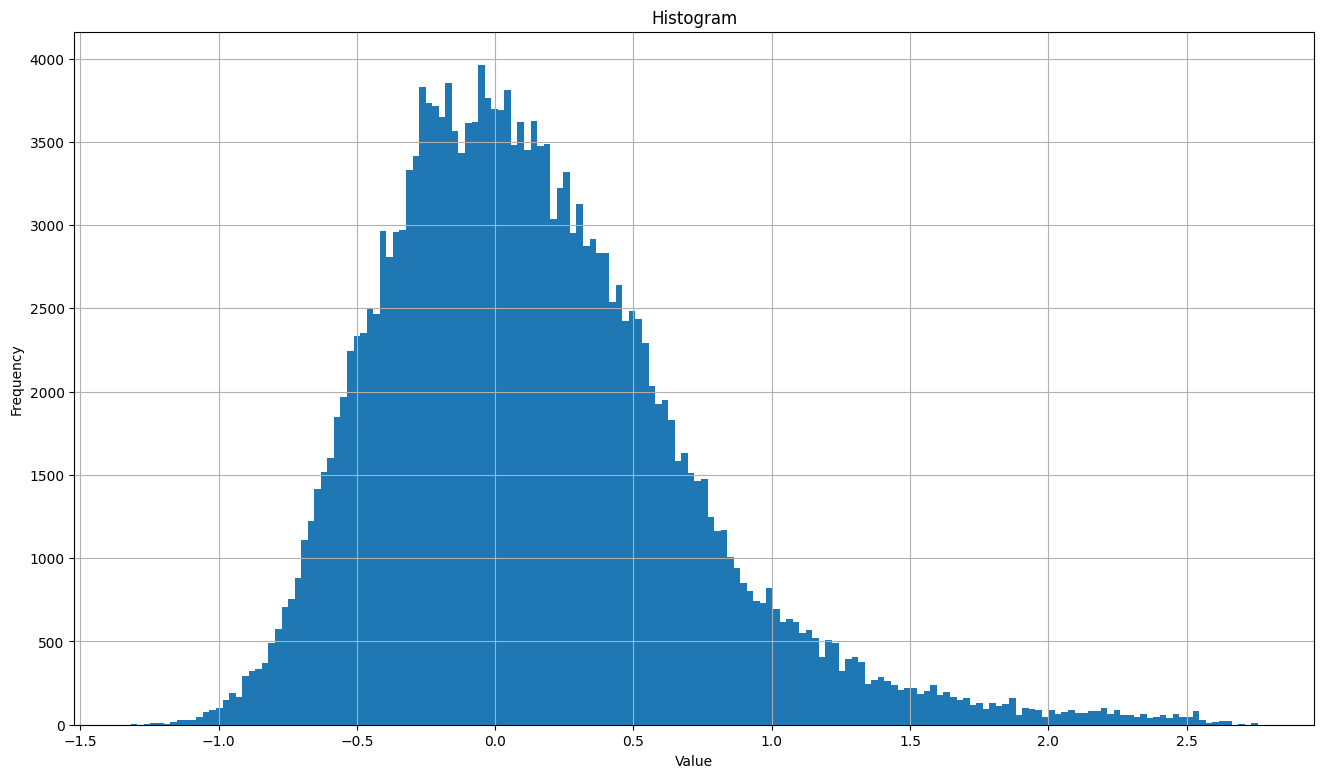

In [39]:
# simulation parameters
steps = 200000
thermal_steps = 200000
max_displacement = 0.3
KCALPERMOL=627.5094736
BOHR=0.52917721
MPROT=1836.15 
CM1=219471.52
KELVIN=3.15774e5
mass=MPROT
planck_c = 1
num_path_var = 8
#potential parameters
xmax=1.5/BOHR
D=20./KCALPERMOL
a=1.*BOHR
beta = 3.15774e5/1200 #1200 kelvin
# parameters for wave function measurements (x histogram)
histo_range = (-1.5, 3.0)
histo_bins = 200
histo_samples = 100

# initialize configuration and observables
c = Config(beta, num_path_var, D, a, eta=1, qmax=xmax, mass = mass)
potential_energy = np.empty(steps, dtype=float)
kinetic_energy = np.empty(steps, dtype=float)
dens = np.empty(steps, dtype=float)
position_histogram = np.zeros((histo_samples, histo_bins))
acc_rate = 0.

# thermalize configuration
print('Thermalization (' + str(thermal_steps) + ' sweeps)...')
for i in range(thermal_steps):
    c.sweep(max_displacement)

# simulation: measures after each update sweep
print('Simulation (' + str(steps) + ' sweeps)')
for i in range(steps):
    acc_rate += c.sweep(max_displacement)

    # Measurements
    potential_energy[i] = c.potential_energy()
    kinetic_energy[i] = c.kinetic_energy()
    position_histogram[i * histo_samples //
                       steps] += c.position_histogram(histo_bins, histo_range)
    dens[i] = c._config[0]

    # Progress marker: one . for each percent
    if i % (steps // 100) == 0:
        stdout.write('.')
        stdout.flush()

# If the acceptance rate is not somewhere around 0.5, max_displacement
# needs to be tuned.
acc_rate /= steps
print('\nAcceptance rate = ' + str(acc_rate))

plt.hist(dens, bins='auto')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.grid(True)
plt.show()


### Measure Observables

In [40]:
# Evaluate results
pot, pot_error, pot_autocorr = stats(potential_energy)
kin, kin_error, kin_autocorr = stats(kinetic_energy)
etot, etot_error, etot_autocorr = stats(potential_energy + kinetic_energy)

# running mean
pot_series = np.cumsum(potential_energy) / np.arange(1, steps + 1)
kin_series = np.cumsum(kinetic_energy) / np.arange(1, steps + 1)

print("Potential Energy = " + str(pot) + " +/- " +
      str(pot_error) + "\tCorrelation time: " + str(pot_autocorr))
print("Kinetic Energy   = " + str(kin) + " +/- " +
      str(kin_error) + "\tCorrelation time: " + str(kin_autocorr))
print("Total Energy     = " + str(etot) + " +/- " + 
      str(etot_error) + "\tCorrelation time: " + str(etot_autocorr))

C:\Users\anton\AppData\Local\Temp\ipykernel_8808\3935231211.py:10: RuntimeWarning: invalid value encountered in divide
  return np.real(pi)[:x.size // 2] / np.sum(xp**2)


Potential Energy = 0.0 +/- 0.0	Correlation time: 0.5
Kinetic Energy   = 0.015193549148723198 +/- 2.3137572242056944e-08	Correlation time: 7.163415432343557
Total Energy     = 0.015193549148723198 +/- 2.3137572242056944e-08	Correlation time: 7.163415432343557


### Plot the observables

[0.00000000e+00 0.00000000e+00 0.00000000e+00 8.21250000e-06
 0.00000000e+00 3.28500000e-05 8.21250000e-06 2.19000000e-05
 6.29625000e-05 3.01125000e-05 1.04025000e-04 1.56037500e-04
 1.99837500e-04 9.85500000e-05 2.40900000e-04 4.02412500e-04
 5.33812500e-04 7.36387500e-04 7.99350000e-04 1.13058750e-03
 1.57132500e-03 1.86971250e-03 2.40352500e-03 3.05505000e-03
 3.64361250e-03 4.04602500e-03 5.18756250e-03 6.12926250e-03
 7.17225000e-03 8.35211250e-03 1.06461375e-02 1.18999125e-02
 1.37203500e-02 1.52944125e-02 1.76842500e-02 2.10185250e-02
 2.29347750e-02 2.66495625e-02 2.87245875e-02 3.11609625e-02
 3.44131125e-02 3.75639750e-02 4.13718375e-02 4.51988625e-02
 4.81444125e-02 4.93188000e-02 5.12761125e-02 5.44653000e-02
 5.92860375e-02 6.12022875e-02 6.29761875e-02 6.55056375e-02
 6.64473375e-02 6.98281500e-02 7.09642125e-02 7.22179875e-02
 7.59300375e-02 7.55084625e-02 7.78408125e-02 7.80406500e-02
 7.62037875e-02 7.66609500e-02 7.86784875e-02 7.92506250e-02
 7.84293750e-02 7.633792

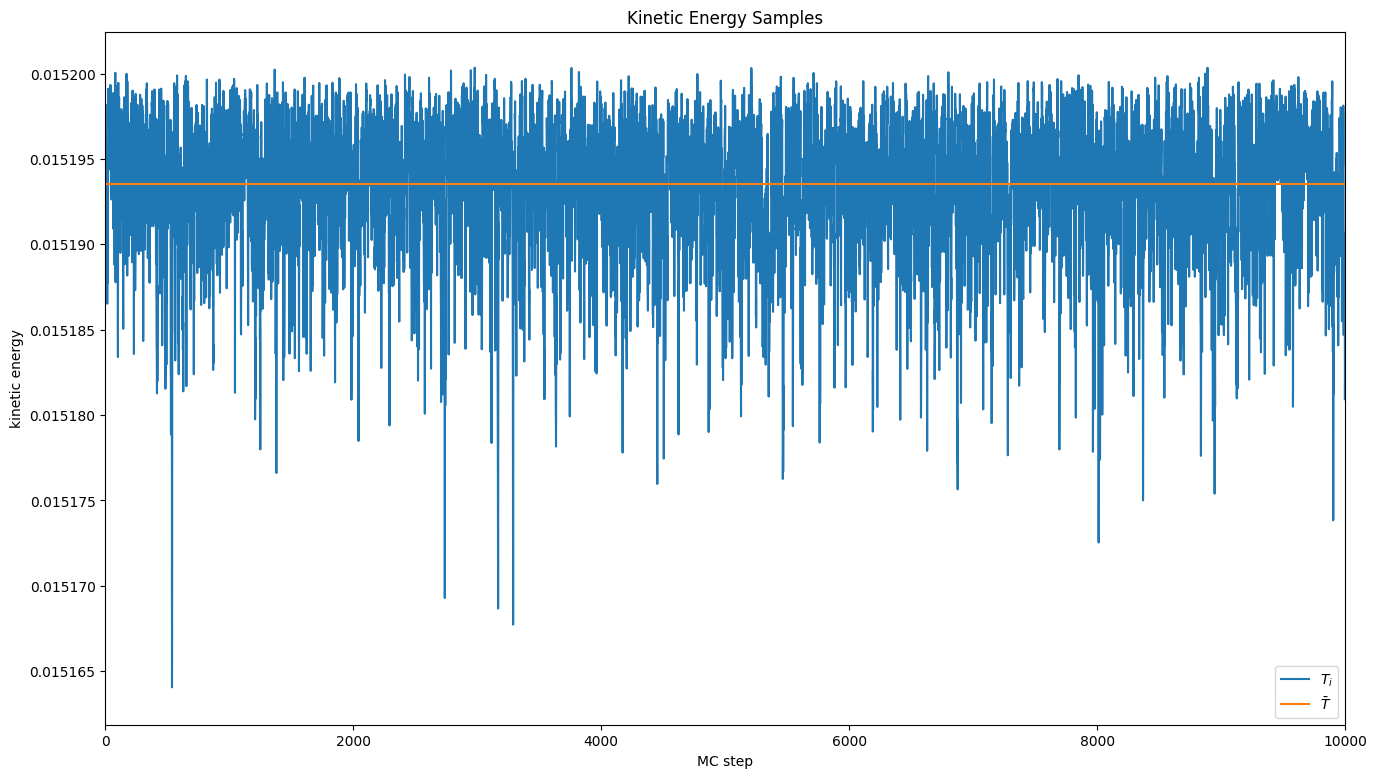

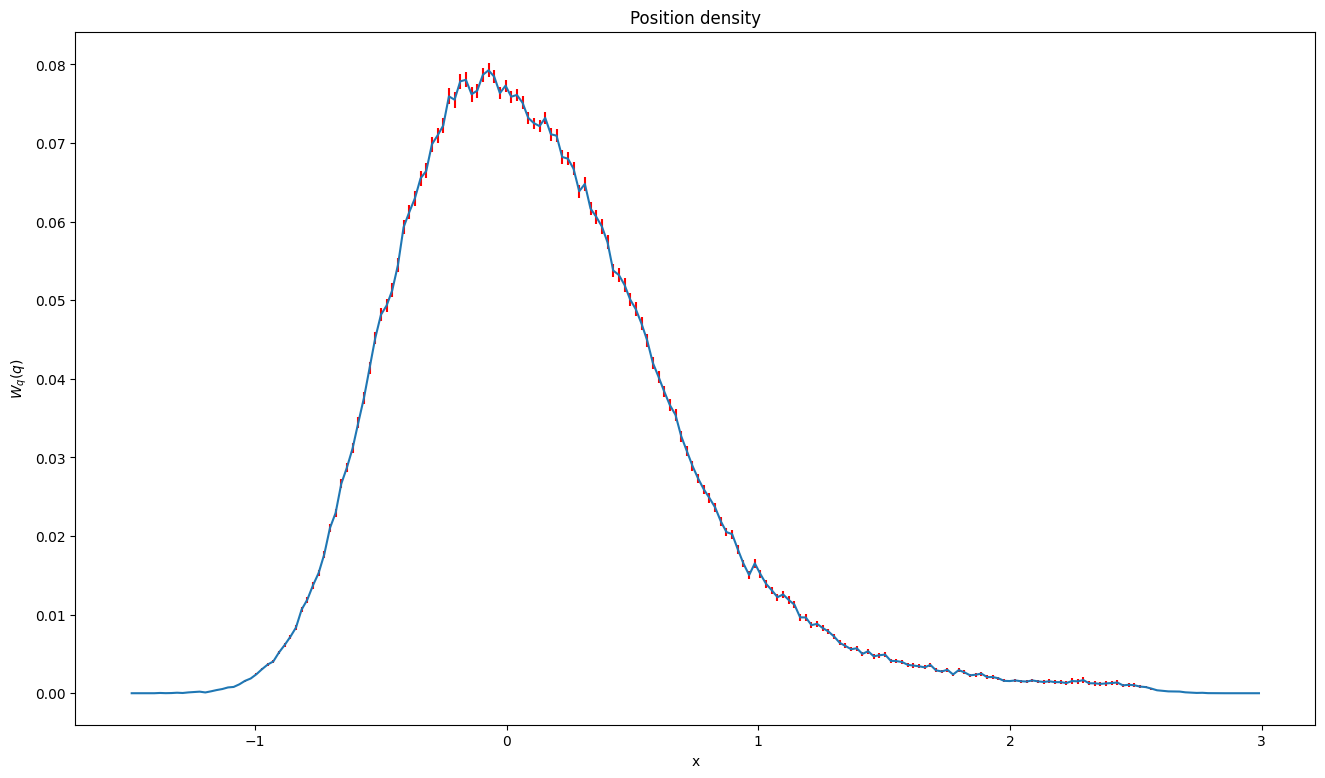

In [49]:
from scipy import integrate, interpolate


# Plot raw samples
plt.figure()
plt.title('Kinetic Energy Samples')
plt.xlabel('MC step')
plt.ylabel('kinetic energy')
plt.plot(range(steps),kinetic_energy,label='$T_i$')
plt.plot([0,steps-1],[kin,kin],label='$\\bar{T}$')
plt.xlim([0, 10000])
plt.legend()

# Normalize histogram and calculate error bars:
# We did not collect a complete time series, but a fixed number of bins.
# This works as long as the size of each bin [steps/histo_samples] >>
# [autocorrelation time]
position_histogram /= np.sum(position_histogram,
                             axis=1).reshape((histo_samples, 1))
histomean = np.mean(position_histogram, axis=0)*4.38
histoerr = np.std(position_histogram, axis=0) / np.sqrt(histo_samples - 1)
print(histomean)
# Plot wave function
plt.figure()
plt.title('Position density')
plt.xlabel('x')
plt.ylabel("$W_q(q)$")
binwidth = (histo_range[1] - histo_range[0]) / histo_bins
plt.errorbar(np.linspace(histo_range[
             0] + binwidth / 2, histo_range[1] - binwidth / 2, histo_bins), histomean, histoerr, ecolor='red')
# plt.plot(np.linspace(histo_range[0], histo_range[1],len(histomean)),histomean, 'g')
plt.show()



(400,)


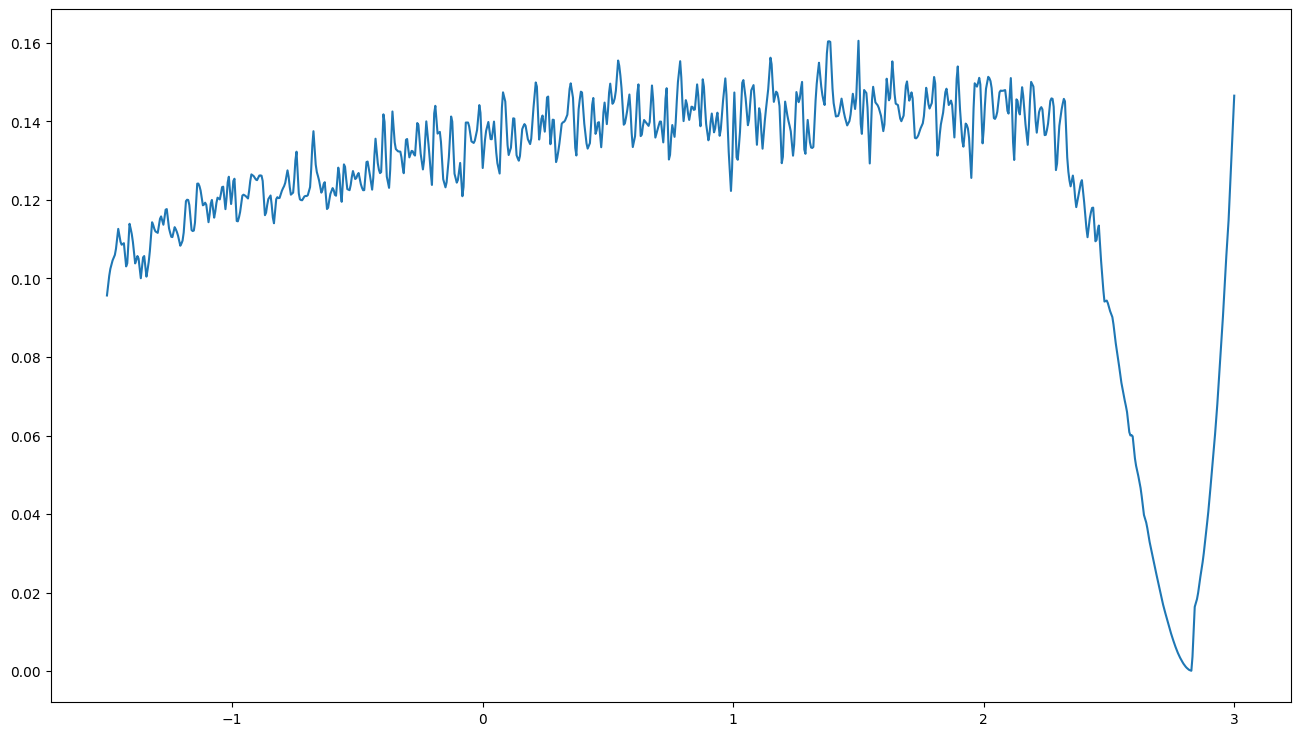

In [51]:
y = np.zeros(400)
with open('finetuned_values.txt', 'r') as file:
    lines = file.readlines()
    for i in range(len(lines)):
      if  i >399:
         break
      y[i] = lines[1 + 3*i].strip()

print(y.shape)
BOHR=0.52917721
x = np.linspace(-1.5,3,400)

interp_func = interpolate.interp1d(x, y, kind='linear', fill_value='extrapolate')

interpolated_y = interp_func(np.linspace(-1.5,3,1000))

plt.plot(np.linspace(-1.5,3,1000), interpolated_y)
plt.show()

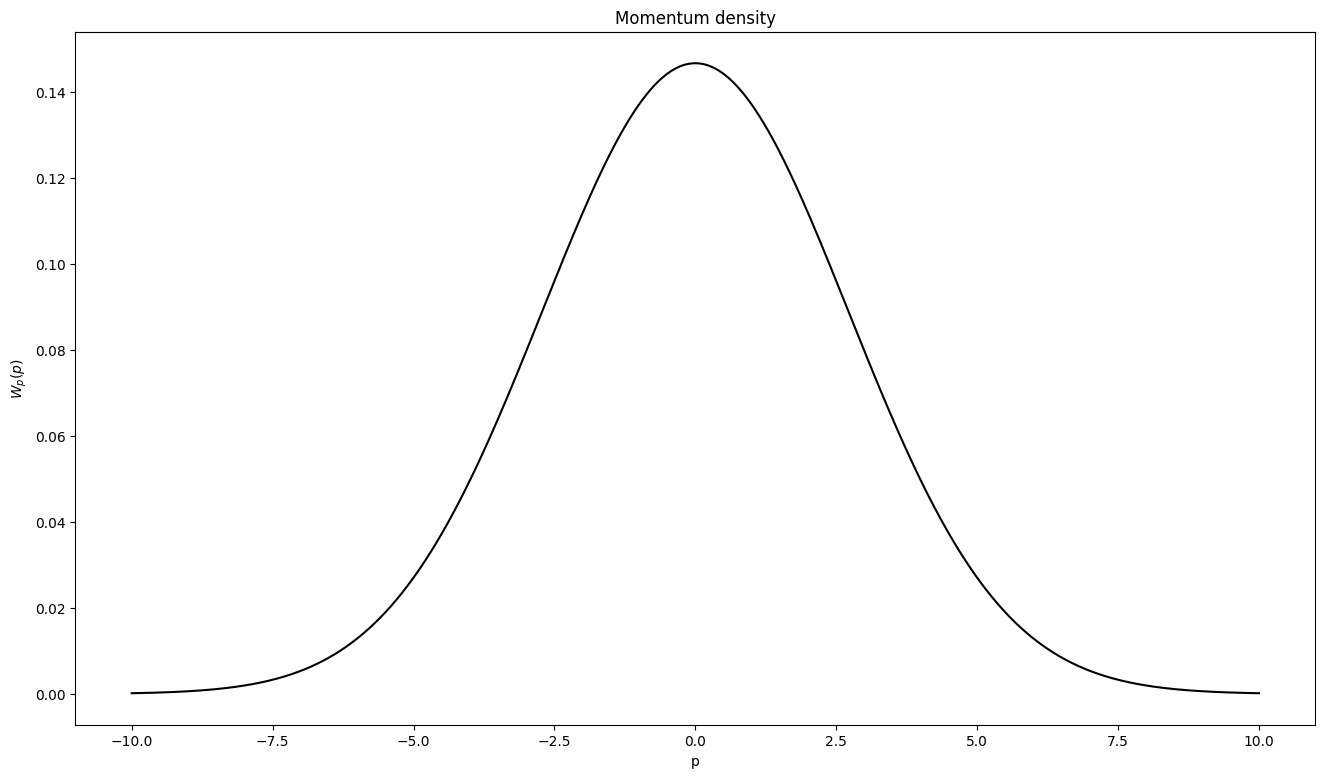

In [52]:
p_grid = np.linspace(-10,10,1000)
hbar = 1
dens = np.zeros(len(p_grid))
for i,p in enumerate(p_grid):
    q = np.linspace(histo_range[
             0] + binwidth / 2, histo_range[1] - binwidth / 2, histo_bins)
    val = 1/(2*np.pi*hbar)*np.sqrt(2*np.pi*interp_func(q))*np.exp(-interp_func(q)*p**2/(2*hbar))*histomean
    dens[i]= integrate.trapz(val, q)
normalization = integrate.trapz(dens,p_grid)
plt.title('Momentum density')
plt.xlabel('p')
plt.ylabel("$W_p(p)$")
plt.plot(p_grid,dens/normalization, 'k' )


morse
Diagonalizing Hamiltonian matrix...
selected states at 1200.0 K (boltzmann threshold=1e-09):
  0 energy: -19.030 kcal/mol, boltzmann weight 5.332e-01, harmonic =0.978 kcal/mol
  1 energy: -17.151 kcal/mol, boltzmann weight 2.425e-01, harmonic =2.935 kcal/mol
  2 energy: -15.343 kcal/mol, boltzmann weight 1.136e-01, harmonic =4.891 kcal/mol
  3 energy: -13.605 kcal/mol, boltzmann weight 5.482e-02, harmonic =6.848 kcal/mol
  4 energy: -11.947 kcal/mol, boltzmann weight 2.735e-02, harmonic =8.804 kcal/mol
  5 energy: -10.376 kcal/mol, boltzmann weight 1.415e-02, harmonic =10.761 kcal/mol
  6 energy: -8.862 kcal/mol, boltzmann weight 7.500e-03, harmonic =12.717 kcal/mol
  7 energy: -7.278 kcal/mol, boltzmann weight 3.860e-03, harmonic =14.674 kcal/mol
  8 energy: -5.488 kcal/mol, boltzmann weight 1.822e-03, harmonic =16.631 kcal/mol
  9 energy: -3.450 kcal/mol, boltzmann weight 7.751e-04, harmonic =18.587 kcal/mol
  10 energy: -1.168 kcal/mol, boltzmann weight 2.977e-04, harmonic =20

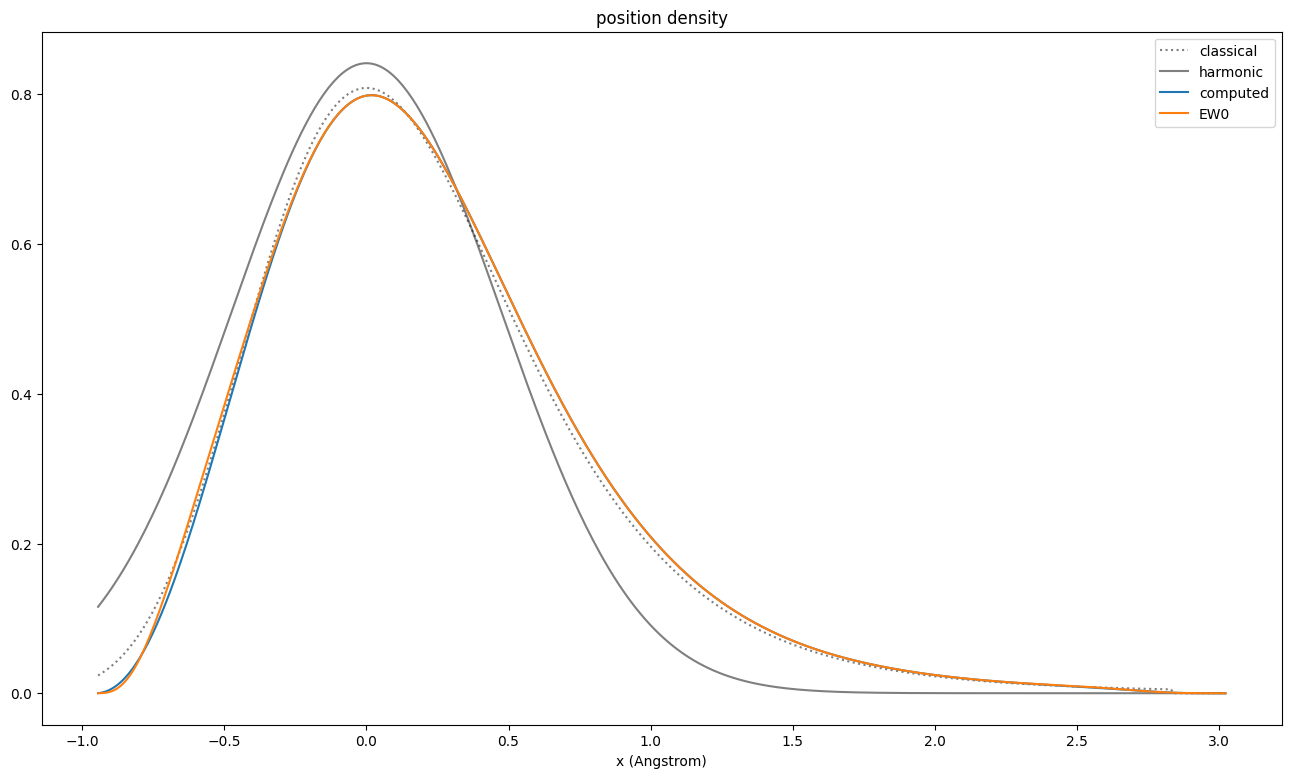

norm_wigner_p= 0.999485072465229
norm_ew0_p= 1.0067114754371282
norm_ecma_p= 0.9980649043223215


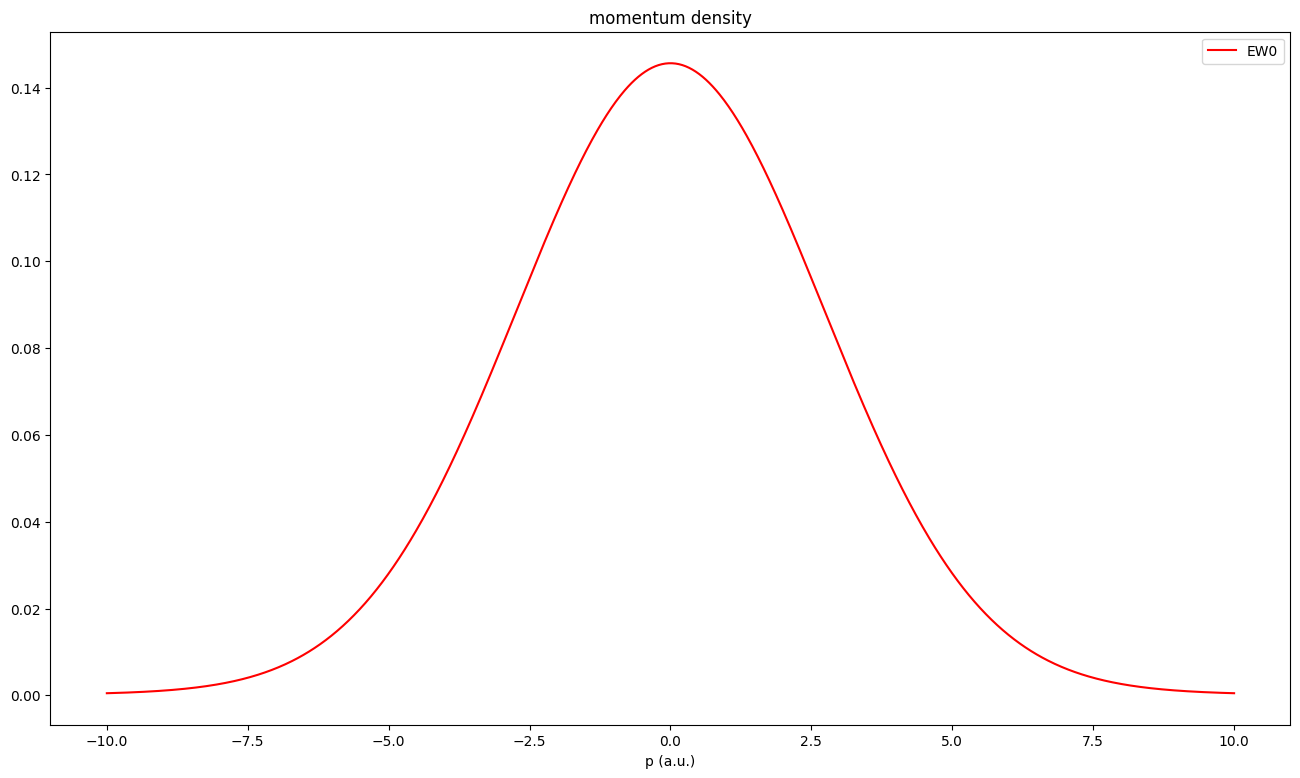

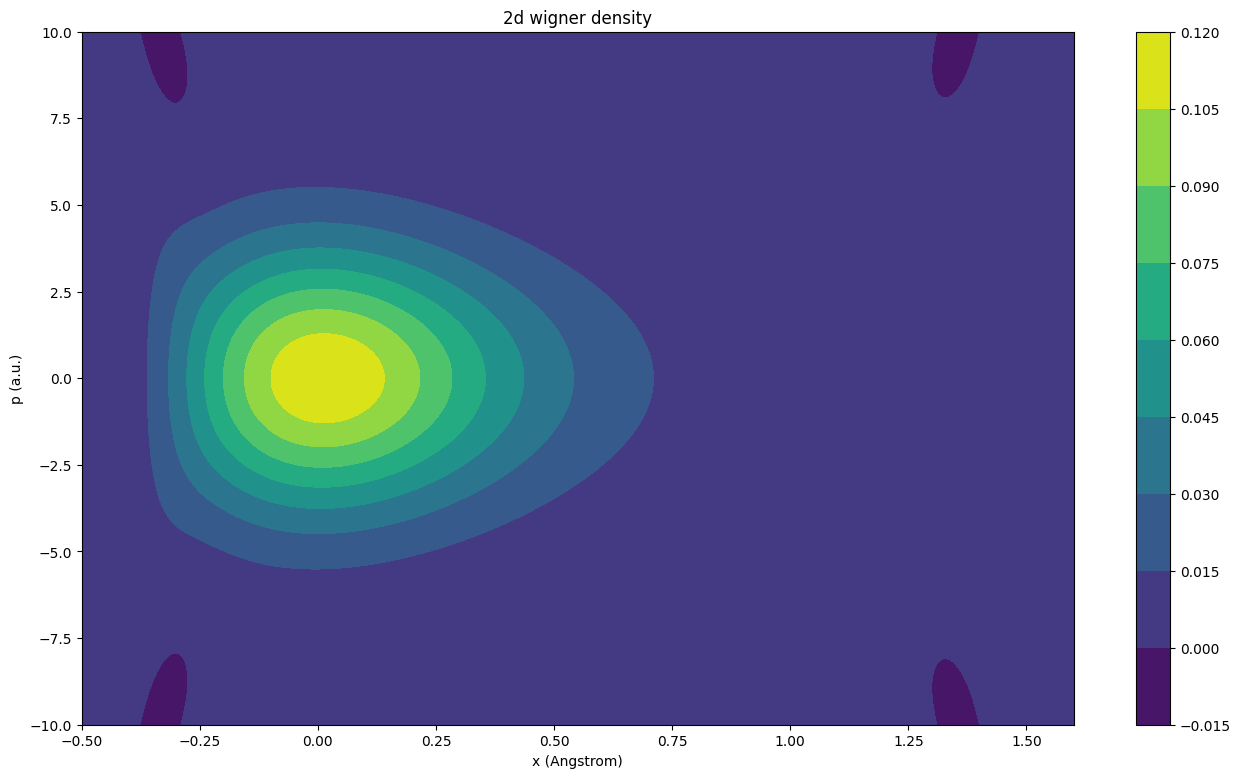

energies and boltzmann factors saved in E_boltz.dat
eigenvectors saved in psi.dat
wigner function saved in wigner.dat
rho(x) saved in rho_x.dat
rho(p) saved in rho_p.dat


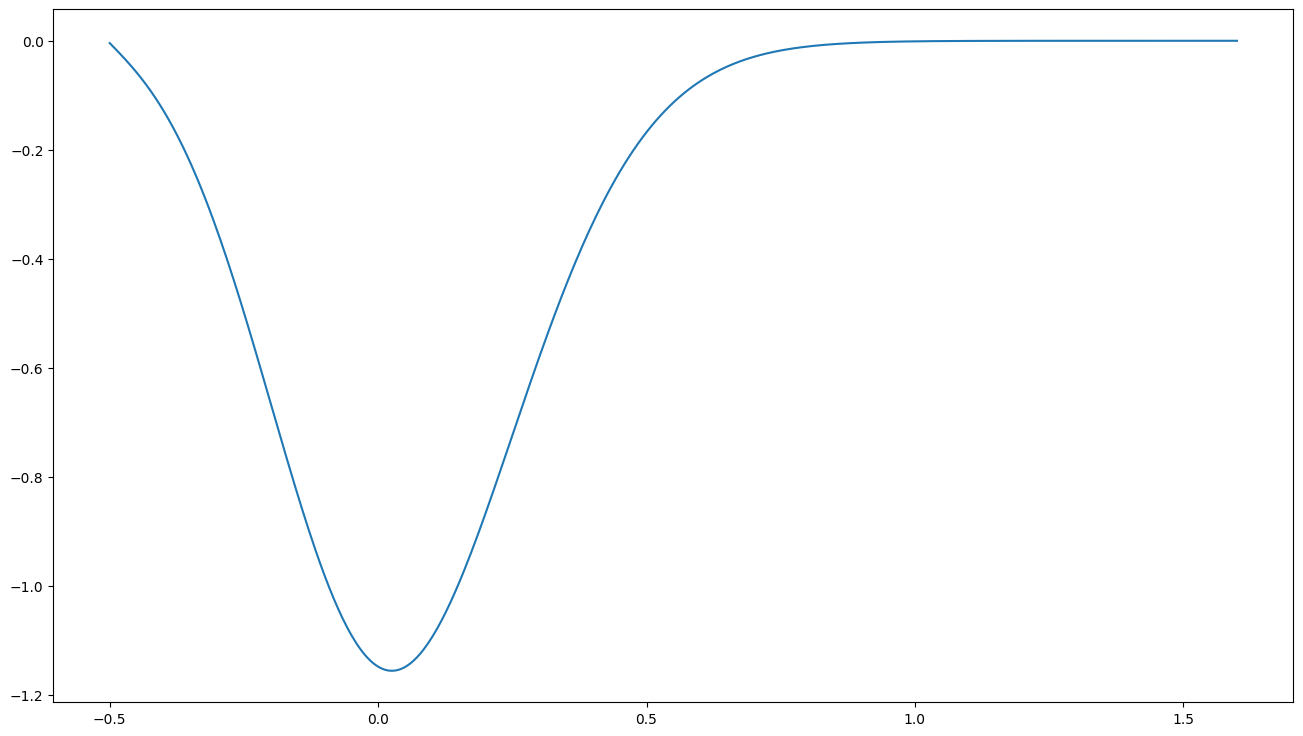

In [56]:
import scipy

KCALPERMOL=627.5094736
BOHR=0.52917721
MPROT=1836.15 
CM1=219471.52
KELVIN=3.15774e5
mass=MPROT

#potential parameters
xmax=1.5/BOHR
D=20./KCALPERMOL
a=1.*BOHR
# w0=1500./CM1
# k0=mass*w0**2
k0=2*D*a**2
w0=np.sqrt(k0/mass)
pot_name="morse"
print(pot_name)

### grid
x=np.linspace(-.5,1.6,500)/BOHR
dx=x[1]-x[0]

dgrid=np.linspace(-1.,1.,2000)/BOHR # grid for end-to-end distance (delta)
dd=dgrid[1]-dgrid[0]
pgrid=np.linspace(-10.,10.,1000) # grid for momentum
dp=pgrid[1]-pgrid[0]

### statistical parameters
kT=1200./KELVIN
thr=1.e-9 ## threshold for boltzmann weight

### harmonic reference
theta=0.5*w0/np.tanh(0.5*w0/kT)
refx=np.exp(-0.5*k0*x**2/theta)/np.sqrt(2*np.pi*theta/k0)
refp=np.exp(-0.5*pgrid**2/mass/theta)/np.sqrt(2*np.pi*mass*theta)

### potential
if pot_name=="morse":
  ex=np.exp(-a*x)
  V=D*ex*(ex-2.)
  V[x>xmax]+=D*np.exp(x[x>xmax]-xmax)
elif pot_name=="harmonic":
  V=0.5*k0*x**2

refx_cl=np.exp(-V/kT)
refx_cl/=refx_cl.sum()*dx
refp_cl=np.exp(-0.5*pgrid**2/mass/kT)/np.sqrt(2*np.pi*mass*kT)

### hamiltonian matrix
k=1./(2*mass*dx**2)
H=np.diag(V+2*k)-np.diag(np.ones(len(x)-1)*k,1)-np.diag(np.ones(len(x)-1)*k,-1)

### diagonalize
print("Diagonalizing Hamiltonian matrix...")
E,Psi=np.linalg.eigh(H)
Psi=Psi/np.sqrt(dx)

rho=np.exp(-(E-E[0])/kT)
Z=np.sum(rho)
rho/=Z

selected_states=rho>thr
rho=rho[selected_states]
E=E[selected_states]
Psi=Psi[:,selected_states]
print(f"selected states at {kT*KELVIN:.1f} K (boltzmann threshold={thr}):")
for i in range(E.shape[0]):
  print(f"  {i} energy: {E[i]*KCALPERMOL:.3f} kcal/mol, boltzmann weight {rho[i]:.3e}, harmonic ={(i+0.5)*w0*KCALPERMOL:.3f} kcal/mol")
#   plt.plot(x*BOHR,Psi[:,i],label=f"E={E[i]:.3e} kcal/mol")
# plt.legend()
# plt.show()

Psi_interp=scipy.interpolate.interp1d(x,Psi,axis=0,kind="linear",fill_value=0.,bounds_error=False)
def end2end(q,d):
  
  return (rho[None,:]*Psi_interp(q-0.5*d)*Psi_interp(q+0.5*d)).sum(axis=1)

# xg=np.linspace(-3.,3.,1000)/BOHR
rhox=end2end(x,0)

wigner=np.zeros((x.shape[0],pgrid.shape[0]))
ew0=np.zeros((x.shape[0],pgrid.shape[0]))
ecma=np.zeros((x.shape[0],pgrid.shape[0]))
ffact=np.cos(pgrid[:,None]*dgrid[None,:])
print("computing wigner function...")
k2=np.zeros_like(x)
for i in range(x.shape[0]):
  e2e=end2end(x[i],dgrid)
  Zd=e2e.sum()*dd
  print(Zd)
  k2[i]=(e2e*dgrid**2).sum()*dd/(1e-08+Zd)
  wigner[i,:]=(e2e[None,:]*ffact).sum(axis=-1)*dd/(2*np.pi)
  ek2=np.exp(-0.5*k2[i]*pgrid**2)
  ew0[i,:]=Zd*ek2/(2*np.pi)
  ecma[i,:]=rhox[i]*ek2/np.sqrt(2*np.pi/(1.e-8+k2[i]))
print("Done!")

print("norm_wigner=",wigner.sum()*dx*dp)
print("norm_ew0=",ew0.sum()*dx*dp)
print("norm_ecma=",ecma.sum()*dx*dp)

ew0x=ew0.sum(axis=1)*dp

plt.plot(x,ew0x,label="EW0")

plt.legend()
plt.show()

rhop=wigner.sum(axis=0)*dx
ew0p=ew0.sum(axis=0)*dx
ecmap=ecma.sum(axis=0)*dx
print("norm_wigner_p=",rhop.sum()*dp)
print("norm_ew0_p=",ew0p.sum()*dp)
print("norm_ecma_p=",ecmap.sum()*dp)
plt.title("momentum density")


plt.plot(pgrid,ew0p,'r',label="EW0")

plt.xlabel("p (a.u.)")
plt.legend()
plt.show()

xw,pw=np.meshgrid(x,pgrid,indexing='ij')
plt.title("2d wigner density")
plt.contourf(xw*BOHR,pw,wigner)
plt.colorbar()
plt.xlabel("x (Angstrom)")
plt.ylabel("p (a.u.)")
plt.show()



# print(E)
np.savetxt("E_boltz.dat",np.column_stack((E,rho)))
print("energies and boltzmann factors saved in E_boltz.dat")
np.savetxt("psi.dat",np.column_stack((x,Psi)))
print("eigenvectors saved in psi.dat")
np.savetxt("wigner.dat",np.column_stack((xw.flatten(),pw.flatten(),wigner.flatten())),header=f"{xw.shape[0]} {xw.shape[1]}")
print("wigner function saved in wigner.dat")
np.savetxt("rho_x.dat",np.column_stack((x,rhox)))
print("rho(x) saved in rho_x.dat")
np.savetxt("rho_p.dat",np.column_stack((pgrid,rhop)))
print("rho(p) saved in rho_p.dat")
plt.plot(x*BOHR,Psi[:,0])
plt.show()
